In [1]:
!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

import requests, zipfile, os
import io
import gc
import psutil

import nltk

# Uncomment if not downloaded
# nltk.download('wordnet')
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [3]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Load the BERT tokenizer and pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Load Data

In [4]:
# Load the dataset
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [5]:
df = pd.DataFrame({
    'Text': newsgroups.data,
    'Category': newsgroups.target
})
df['Category Name'] = df['Category'].apply(lambda x: newsgroups.target_names[x])
df

,Text,Category,Category Name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware
...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,sci.med
18842,\nNot in isolated ground recepticles (usually ...,12,sci.electronics
18843,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware
18844,\nWouldn't this require a hyper-sphere. In 3-...,1,comp.graphics


# Embedding Model

In [6]:
def generate_bert_embeddings_to_file(text_column, batch_size=32, output_file="bert_embeddings.npy", device='/GPU:0', verbose=True):
    """
    This function takes a column of raw text (sentences or documents), processes it in batches, 
    moves computations to GPU (or specified device), clears cache after each batch, and stores
    embeddings in a file to avoid memory issues.
    
    Args:
    - text_column: A pandas Series containing text strings (raw text input).
    - batch_size: The number of samples to process in each batch.
    - output_file: The file path to save the embeddings (default is 'bert_embeddings.npy').
    - device: The device to perform computations on (e.g., '/GPU:0' or '/CPU:0').
    - verbose: If True, prints detailed logs during batch processing.
    
    Returns:
    - None (embeddings are written to a file, batch by batch).
    """
    total_batches = (len(text_column) // batch_size) + 1
    
    if verbose:
        print(f"Starting BERT embeddings generation on device: {device}")
        print(f"Total samples: {len(text_column)}, Batch size: {batch_size}, Total batches: {total_batches}")
    
    # Create an empty list to store embeddings temporarily (in case you need to accumulate for writing)
    batch_embeddings = []
    
    # Process the data in batches to avoid memory issues
    for i in range(0, len(text_column), batch_size):
        batch_texts = text_column[i:i+batch_size].tolist()
        
        if verbose:
            print(f"\nProcessing batch {i // batch_size + 1}/{total_batches} (samples {i} to {i + batch_size - 1})")
            print(f"Current memory usage: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")
        
        with tf.device(device):  # Move computations to specified device (GPU or CPU)
            # Tokenize the batch of raw text inputs for BERT
            tokenized_inputs = tokenizer(batch_texts, return_tensors='tf', padding=True, truncation=True, max_length=128)
            
            # Get BERT embeddings for the current batch
            bert_outputs = bert_model(tokenized_inputs['input_ids'], attention_mask=tokenized_inputs['attention_mask'])
            
            # Extract the last hidden states (embeddings)
            embeddings_batch = bert_outputs.last_hidden_state.numpy()  # Shape: (batch_size, max_sequence_length, hidden_size)
        
        # Append to batch embeddings list
        batch_embeddings.append(embeddings_batch)
        
        # Save the batch embeddings to a file
        if os.path.exists(output_file):
            # If the file already exists, append to it
            with open(output_file, 'ab') as f:
                np.save(f, embeddings_batch)
        else:
            # If it's the first batch, create the file
            with open(output_file, 'wb') as f:
                np.save(f, embeddings_batch)
        
        # Clear TensorFlow cache after each batch to free up memory
        gc.collect()
        tf.keras.backend.clear_session()
        
        if verbose:
            print(f"Batch {i // batch_size + 1} processed and written to file, clearing cache...")
            print(f"Memory usage after cache clearing: {psutil.virtual_memory().used / (1024 ** 3):.2f} GB")
    
    if verbose:
        print(f"\nBERT embeddings generation completed and saved to {output_file}.")

In [7]:
df['Embeddings'] = generate_bert_embeddings_to_file(df['Text'], batch_size=32, output_file="bert_embeddings.npy", device='/GPU:0', verbose=True)

Starting BERT embeddings generation on device: /GPU:0
Total samples: 18846, Batch size: 32, Total batches: 589

Processing batch 1/589 (samples 0 to 31)
Current memory usage: 2.02 GB
Batch 1 processed and written to file, clearing cache...
Memory usage after cache clearing: 2.04 GB

Processing batch 2/589 (samples 32 to 63)
Current memory usage: 2.04 GB
Batch 2 processed and written to file, clearing cache...
Memory usage after cache clearing: 2.05 GB

Processing batch 3/589 (samples 64 to 95)
Current memory usage: 2.05 GB
Batch 3 processed and written to file, clearing cache...
Memory usage after cache clearing: 2.07 GB

Processing batch 4/589 (samples 96 to 127)
Current memory usage: 2.07 GB
Batch 4 processed and written to file, clearing cache...
Memory usage after cache clearing: 2.08 GB

Processing batch 5/589 (samples 128 to 159)
Current memory usage: 2.08 GB
Batch 5 processed and written to file, clearing cache...
Memory usage after cache clearing: 2.09 GB

Processing batch 6/58

In [8]:
def load_embeddings_from_file(embedding_file):
    """
    Load embeddings saved in .npy file batch by batch.
    
    Args:
    - embedding_file: The path to the .npy file where the embeddings are stored.
    
    Returns:
    - A list of all embeddings loaded from the file.
    """
    all_embeddings = []
    with open(embedding_file, 'rb') as f:
        try:
            while True:
                batch_embeddings = np.load(f)
                all_embeddings.extend(batch_embeddings)  # Append batch embeddings to the overall list
        except EOFError:
            pass
    return all_embeddings

# Step 2: Load embeddings and assign them to the DataFrame column
def add_embeddings_to_df(df, embedding_file, column_name='Embeddings'):
    """
    Add embeddings from the .npy file to a DataFrame as a new column.
    
    Args:
    - df: The original DataFrame with the text data.
    - embedding_file: Path to the .npy file where the embeddings are stored.
    - column_name: The name of the column to store the embeddings.
    
    Returns:
    - DataFrame with the embeddings column added.
    """
    # Load embeddings from the file
    embeddings = load_embeddings_from_file(embedding_file)
    
    # Ensure embeddings match the number of rows in the DataFrame
    if len(embeddings) != len(df):
        raise ValueError("Number of embeddings does not match the number of rows in the DataFrame.")
    
    # Add embeddings to the DataFrame
    df[column_name] = embeddings
    return df

In [9]:
df = add_embeddings_to_df(df, 'bert_embeddings.npy', column_name='Embeddings')

In [10]:
X = np.array(df['Embeddings'].tolist())
y = df['Category'] 

In [11]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the splits
print("Shape of X_train:", X_train.shape)  # Should be (number_of_train_samples, max_length, embedding_dim)
print("Shape of y_train:", y_train.shape)  # Should be (number_of_train_samples, number_of_classes)
print("Shape of X_test:", X_test.shape)    # Should be (number_of_test_samples, max_length, embedding_dim)
print("Shape of y_test:", y_test.shape)    # Should be (number_of_test_samples, number_of_classes)

Shape of X_train: (15076, 128, 768)
Shape of y_train: (15076,)
Shape of X_test: (3770, 128, 768)
Shape of y_test: (3770,)


In [ ]:
import joblib

# Example: Save the data to a .pkl file using joblib
joblib.dump((X_train, y_train, X_test, y_test), '/kaggle/working/bert_train_test_data.pkl')

In [4]:
# Load the data
X_train, y_train, X_test, y_test = joblib.load('/kaggle/working/bert_train_test_data.pkl')

# Define Model

In [5]:
# Define the LSTM model with additional dense layers
max_sequence_length, embedding_dim = 128, 768
model = Sequential()
model.add(LSTM(128, input_shape=(max_sequence_length, embedding_dim), return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

# Define cosine annealing learning rate schedule
cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=0.0005,
    first_decay_steps=20,
    t_mul=2,
    alpha=0.01
)
# Compile the model using this schedule
optimizer = Adam(learning_rate=cosine_annealing)

# Compile the model using the custom learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',     # Monitor the validation loss
    patience=20,             # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the weights of the best epoch if no improvement
)

# Summary of the model
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │       459,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 470,260 (1.79 MB)

 Trainable params: 470,260 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Assuming you have defined your LSTM model already
print("Is GPU available:", tf.test.is_gpu_available())

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    epochs=200,                      # Maximum number of epochs
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],      # Add early stopping callback
    verbose=1
)

Is GPU available: True
Epoch 1/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.1302 - loss: 2.7921 - val_accuracy: 0.3989 - val_loss: 1.8869
Epoch 2/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3637 - loss: 1.9295 - val_accuracy: 0.5114 - val_loss: 1.4907
Epoch 3/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4779 - loss: 1.5857 - val_accuracy: 0.5199 - val_loss: 1.4390
Epoch 4/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5071 - loss: 1.4898 - val_accuracy: 0.5660 - val_loss: 1.3127
Epoch 5/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5763 - loss: 1.2906 - val_accuracy: 0.5912 - val_loss: 1.2365
Epoch 6/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5980 - loss: 1.2407 - val_accuracy: 0.5891 - val_loss: 1.2606
Epoch 7/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.6042 - loss: 1.2329 - val_accuracy: 0.6117 - val_loss: 1.1900
Epoch 8/200
472/472 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 

In [7]:
# Extract and store the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

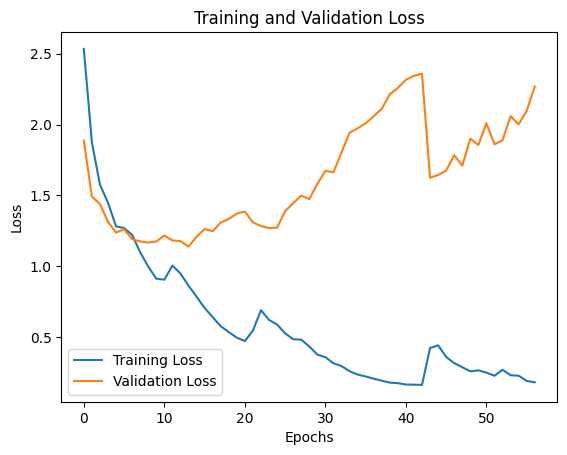

In [8]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

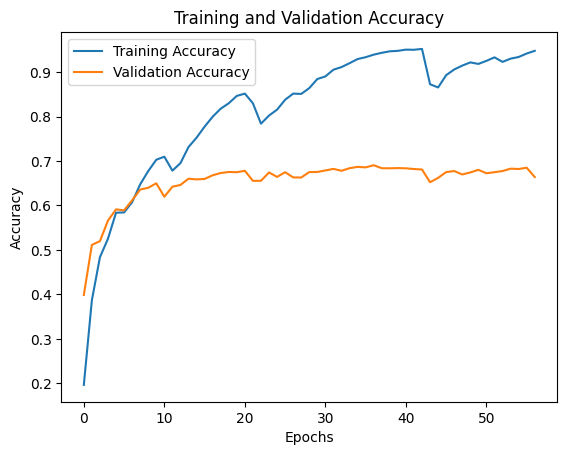

In [9]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [10]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6838 - loss: 2.1556
Test Loss: 2.059417486190796
Test Accuracy: 0.69045090675354
